# Transfer Learning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
import warnings
warnings.filterwarnings('ignore')

In [2]:
def set_seed(seed):
    """Set ALL the random seeds to a fixed value and take out any randomness from cuda kernels."""

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms.
                                            # Useful when inputs do not change size.
    torch.backends.cudnn.enabled   = False

    return True

In [3]:
# Set up device
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    device = 'cpu'

No GPU available!


Transfer setting is a machine learning technique where a model trained on one task is re-purposed on another task.

เราสามารถเอา CNN ที่มีในอินเทอร์เน็ต ที่ถูก trained โดยใช้ข้อมูลปริมาณมาก มาใช้ในงานของเราที่คล้ายกันแต่มีข้อมูลน้อยกว่า ไม่ต้อง train from scratch (ค่าของ parameter ของ model ตั้งต้นถูกสุ่มขึ้นมา) วิธีการที่ทำได้ เช่น
- <b>Add one (or more) layers, or retrain the last layer(s) of a pre-trained network</b>: This strategy assumes that the filters of most of the network do a good job at extracting data features we can use. The last layers, then, act as a final fine-tunning to capture the specific features of our data.
- <b>Retrain the whole network with small learning rates</b>: This strategy assumes that as a whole, the network captures data features well, and it only needs a bit of a ‘nudge’ to adapt the network parameters to our particular problem. In this case, we want to keep the underlying abstraction that the network does at different scales, but fine-tune it to our problem.

ข้อดีของ transfer learning เช่น
- prevent poor training from random weights when only small datasets are available.
- reduce training time for tasks that use data with 'similar' distributions.

We will apply transfer learning to a small dataset containing images of bees and ants by transfering learning done by training with the ImageNet dataset.

ImageNet is arguably the most popular dataset for benchmarking classification models. It contains around 14 million annotated natural images spread over 22 thousand categories. Images are of size 3 x 224 x 224, with normalised means and stds of [0.485, 0.456, 0.406] and [0.229, 0.224, 0.225]. In transfer learning is common practice to use the means and standard deviations of the data used for pretraining to normalise the new dataset. Note that the most popular networks (VGG, ResNet, AlexNet, etc..) have been design to take as input 3 x 224 x 224 images to accomodate for ImageNet.

```
# Download the dataset, unzip it, and move the zipped and unzipped ones
# from the current folder to the "../data" directory
# (ต้องติดตั้ง 7-Zip ก่อน แล้ว copy directory มาเพิ่มใน System Path)
!curl -k -O https://download.pytorch.org/tutorial/hymenoptera_data.zip
!7z x -aoa hymenoptera_data.zip
!move hymenoptera_data.zip ../data
!move hymenoptera_data ../data
```

```
# Download the dataset and unzip it in Google Colab
# !wget -nc https://download.pytorch.org/tutorial/hymenoptera_data.zip && unzip -oq hymenoptera_data.zip
```

In [4]:
# The path to the dataset
data_path = "../data/hymenoptera_data"

In [5]:
# Hyperparameters
seed = 42
lr = 1e-2
momentum = 0.9
batch_size = 64
test_batch_size = 1000
n_epochs = 30

In [6]:
# Create a transform (only convert images to tensors)
transform = transforms.Compose([transforms.ToTensor()])

# Prepare training and test sets
train_ds = datasets.ImageFolder(f"{data_path}/train", transform=transform)
test_ds = datasets.ImageFolder(f"{data_path}/val", transform=transform)

# Print the information about the training set
print(train_ds, '\n')
print(train_ds.classes, '\n')
print(train_ds.class_to_idx, '\n')
print(train_ds[0], '\n')  # Calling __getitem__, which is what the dataloader does
print(train_ds.samples[0], '\n') # get image path inside samples

# Get mean and std
tmp_loader = DataLoader(train_ds, batch_size=1, num_workers=0)
data = next(iter(tmp_loader))
mean = [torch.mean(data[0][0][i].flatten()).item() for i in range(3)]
std = [torch.std(data[0][0][i].flatten()).item() for i in range(3)]
print(mean, std)

Dataset ImageFolder
    Number of datapoints: 244
    Root location: ../data/hymenoptera_data/train
    StandardTransform
Transform: Compose(
               ToTensor()
           ) 

['ants', 'bees'] 

{'ants': 0, 'bees': 1} 

(tensor([[[0.3137, 0.3137, 0.3137,  ..., 0.3176, 0.3098, 0.2980],
         [0.3176, 0.3176, 0.3176,  ..., 0.3176, 0.3098, 0.2980],
         [0.3216, 0.3216, 0.3216,  ..., 0.3137, 0.3098, 0.3020],
         ...,
         [0.3412, 0.3412, 0.3373,  ..., 0.1725, 0.3725, 0.3529],
         [0.3412, 0.3412, 0.3373,  ..., 0.3294, 0.3529, 0.3294],
         [0.3412, 0.3412, 0.3373,  ..., 0.3098, 0.3059, 0.3294]],

        [[0.5922, 0.5922, 0.5922,  ..., 0.5961, 0.5882, 0.5765],
         [0.5961, 0.5961, 0.5961,  ..., 0.5961, 0.5882, 0.5765],
         [0.6000, 0.6000, 0.6000,  ..., 0.5922, 0.5882, 0.5804],
         ...,
         [0.6275, 0.6275, 0.6235,  ..., 0.3608, 0.6196, 0.6157],
         [0.6275, 0.6275, 0.6235,  ..., 0.5765, 0.6275, 0.5961],
         [0.6275, 0.6275, 0

In [7]:
def show_batch(dataset, nr=4, nc=4):
    """Plot images randomly chosen from an image dataset."""
    fig, axarr = plt.subplots(nr, nc, figsize=(10, 10))
    for i in range(nr):
        for j in range(nc):
            idx = random.randint(0, len(dataset)-1)
            sample, target = dataset[idx]
            try:  # If PIL
                axarr[i][j].imshow(sample)
            except:  # If tensor of shape torch.Size(channel, height, width)
                axarr[i][j].imshow(sample.permute(1, 2, 0))
            target_name = dataset.classes[target]
            axarr[i][j].set_title("%s (%i)" % (target_name, target))

    fig.tight_layout(pad=1.5)
    plt.show()

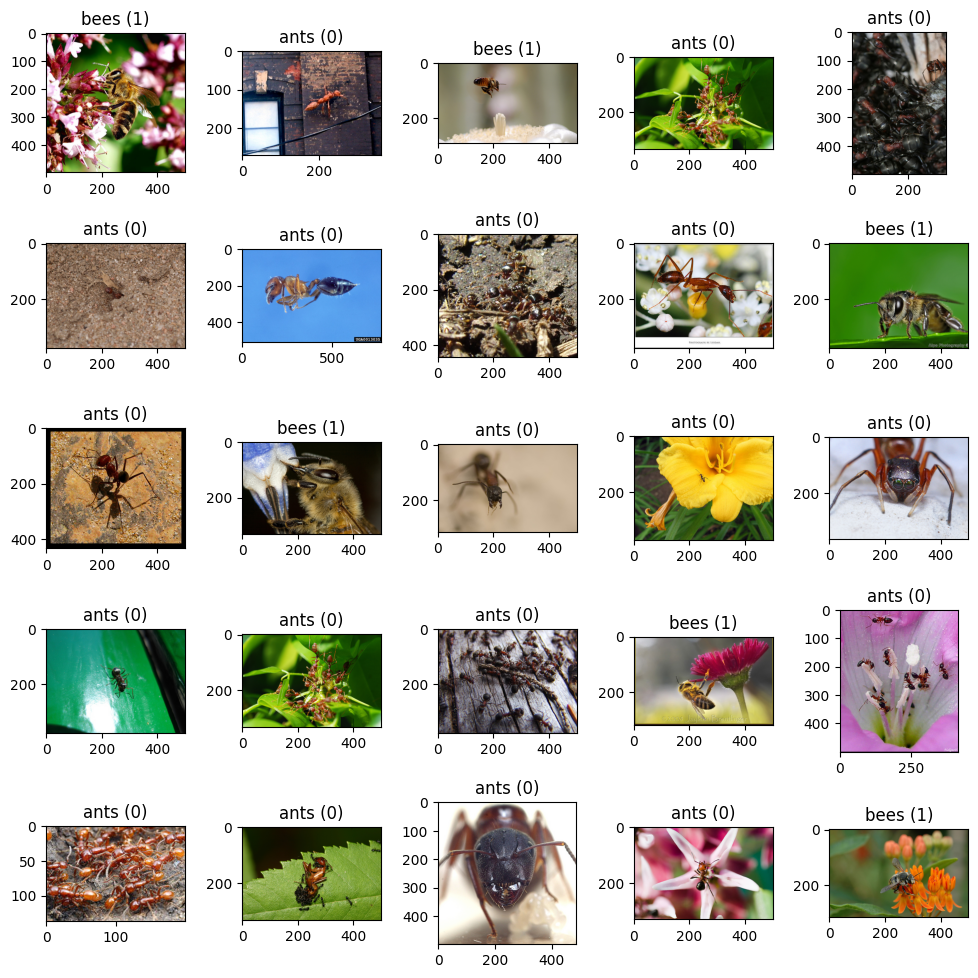

In [8]:
show_batch(train_ds, 5, 5)

In [9]:
# Mean and std typically used for pre-trained models on ImageNet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Create a new transform for the training set
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Crop a random portion of each image and resize it to 224
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally (the probability is 0.5 by default)
    transforms.ToTensor(),              # Convert images to tensors
    transforms.Normalize(mean, std),    # Normalise images
])

# Create a new transform for the test set
test_transform = transforms.Compose([
    transforms.Resize(256),           # Resize images to 256
    transforms.CenterCrop(224),       # Crop images at the center
    transforms.ToTensor(),            # Convert images to tensors
    transforms.Normalize(mean, std),  # Normalise images
])

# Prepare training and test sets
train_ds = datasets.ImageFolder(f"{data_path}/train", transform=train_transform)
test_ds = datasets.ImageFolder(f"{data_path}/val", transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

In [10]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 3, 224, 224))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(
            y.cpu().numpy(), y_pred.detach().cpu().numpy()
        )*X.size(0)
        optimizer.step()
    avg_train_loss = train_loss/len(data_loader.dataset)
    avg_train_accuracy = train_accuracy/len(data_loader.dataset)
    return avg_train_loss, avg_train_accuracy

def validate(model, criterion, data_loader):
    model.eval()
    val_loss, val_accuracy = 0, 0
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 224, 224))
            loss = criterion(a2, y)
            val_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            val_accuracy += accuracy_score(
                y.cpu().numpy(), y_pred.cpu().numpy()
            )*X.size(0)
    avg_val_loss = val_loss/len(data_loader.dataset)
    avg_val_accuracy = val_accuracy/len(data_loader.dataset)
    return avg_val_loss, avg_val_accuracy

def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 224, 224))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
    return np.concatenate(ys, 0), np.concatenate(y_preds, 0)

In [11]:
# Prepare the pre-trained ResNet-18 model, optimiser and loss function
set_seed(seed)
model = models.resnet18(pretrained=True).to(device)
model.fc = nn.Linear(model.fc.in_features, 2).to(device)  # Modify the fully connected (fc) layer of the model
                                                          # to output 2 classes (ants (0) and bees (1) in this case)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1*lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

In [12]:
# Fine-tune the pre-trained ResNet-18 model and plot its learning curves
# You can use the "livelossplot" module to plot a real-time evolution of loss and accuracy
set_seed(seed)
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
for epoch in range(n_epochs):
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss.item())
    train_accuracies.append(train_accuracy.item())
    val_loss, val_accuracy = validate(model, criterion, test_loader)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())

KeyboardInterrupt: 

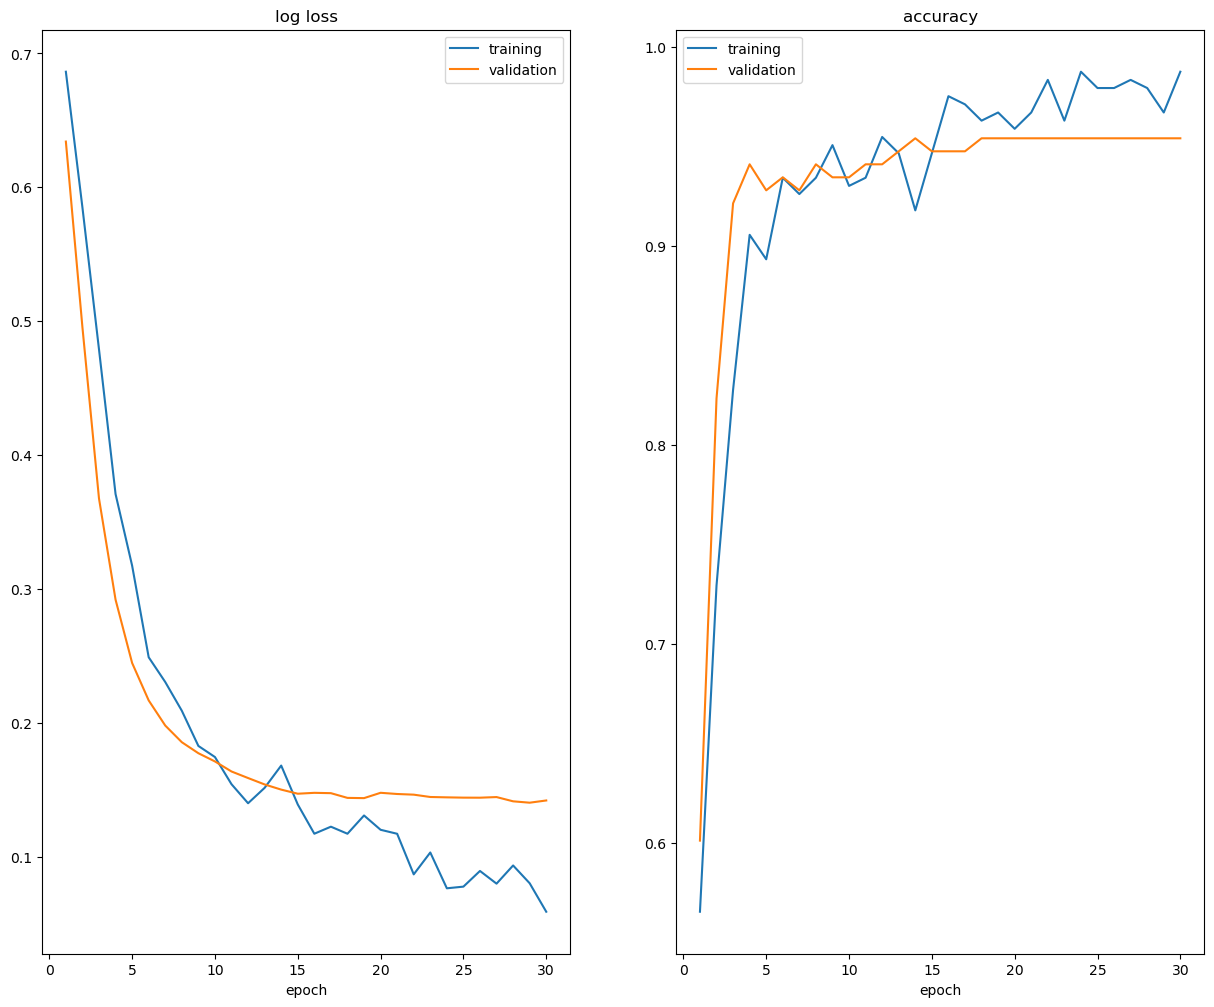

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 12))
axes[0].plot(range(1, n_epochs+1), train_losses, label="training")
axes[0].plot(range(1, n_epochs+1), val_losses, label="validation")
axes[0].set(title="log loss", xlabel="epoch")
axes[0].legend()
axes[1].plot(range(1, n_epochs+1), train_accuracies, label="training")
axes[1].plot(range(1, n_epochs+1), val_accuracies, label="validation")
axes[1].set(title="accuracy", xlabel="epoch")
axes[1].legend();

In [14]:
# Change our training to only update the last layer of the network

def set_parameter_requires_grad(model, requires_grad=False):
    """https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html"""
    for param in model.parameters():
        param.requires_grad = requires_grad
    return None

def get_params_to_update(model):
    """ Returns list of model parameters that have required_grad=True"""
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
    return params_to_update

In [15]:
# Prepare the pre-trained ResNet-18 model, optimiser and loss function
set_seed(seed)
model = models.resnet18(pretrained=True).to(device)
set_parameter_requires_grad(model, requires_grad=False)
model.fc = nn.Linear(model.fc.in_features, 2).to(device)  # Newly initialised layers automatically have
                                                          # requires_grad=True
optimizer = torch.optim.SGD(get_params_to_update(model), lr=0.1*lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

In [16]:
# Train the last layer of the network and plot the learning curves
# You can use the "livelossplot" module to plot a real-time evolution of loss and accuracy
set_seed(seed)
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
for epoch in range(n_epochs):
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss.item())
    train_accuracies.append(train_accuracy.item())
    val_loss, val_accuracy = validate(model, criterion, test_loader)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())

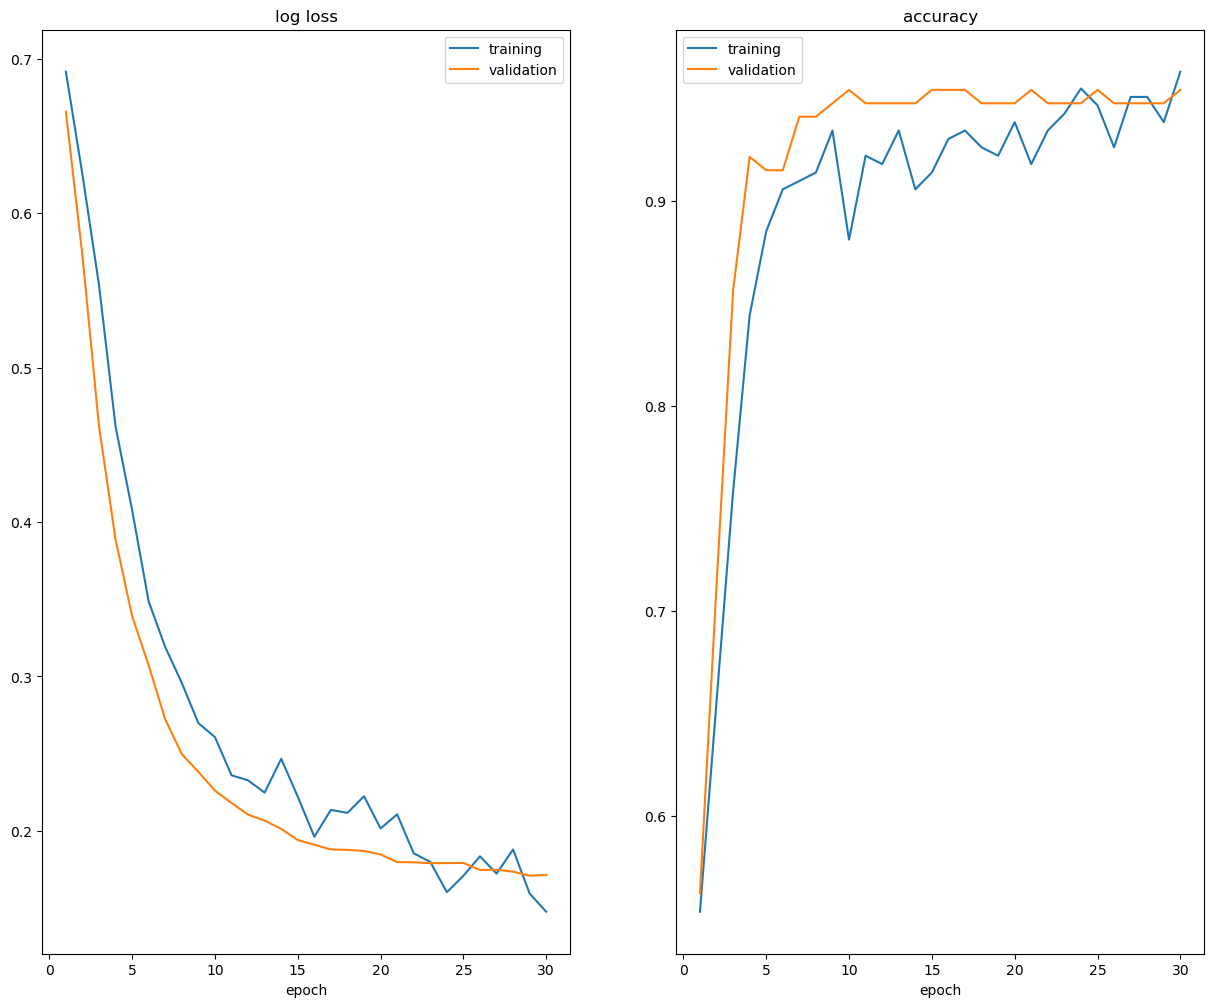

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 12))
axes[0].plot(range(1, n_epochs+1), train_losses, label="training")
axes[0].plot(range(1, n_epochs+1), val_losses, label="validation")
axes[0].set(title="log loss", xlabel="epoch")
axes[0].legend()
axes[1].plot(range(1, n_epochs+1), train_accuracies, label="training")
axes[1].plot(range(1, n_epochs+1), val_accuracies, label="validation")
axes[1].set(title="accuracy", xlabel="epoch")
axes[1].legend();